## geoJSON

#### Class objectives
- Identify the geoJSON format
- Update mongo documents
- Create an 2d index in mongo
- Geoqueries

#### Challenges
- Calculating the distance between two companies
- Finding all the companies within a certain radius of a given point

In [62]:
from pymongo import MongoClient

In [63]:
client = MongoClient()
db = client.get_database("datamad1020")

In [64]:
comp = db.companies

In [65]:
res = list(db.companies.find({"offices.latitude":{"$ne":None}},{"offices":1}).limit(2))

In [66]:
res

[{'_id': ObjectId('52cdef7c4bab8bd675297d8b'),
  'offices': [{'description': 'Headquarters',
    'address1': '4900 Hopyard Rd.',
    'address2': 'Suite 310',
    'zip_code': '94588',
    'city': 'Pleasanton',
    'state_code': 'CA',
    'country_code': 'USA',
    'latitude': 37.692934,
    'longitude': -121.904945}]},
 {'_id': ObjectId('52cdef7c4bab8bd675297d90'),
  'offices': [{'description': None,
    'address1': '959 Skyway Road, Suite 200',
    'address2': None,
    'zip_code': '94070',
    'city': 'San Carlos',
    'state_code': 'CA',
    'country_code': 'USA',
    'latitude': 37.506885,
    'longitude': -122.247573}]}]

In [67]:
coord = [(e["offices"][0]["latitude"],e["offices"][0]["longitude"]) for e in res]
coord

[(37.692934, -121.904945), (37.506885, -122.247573)]

In [68]:
# Calculating the Euclidean distance
# for points on the globe is a BIG mistake.
# Latitude and Longitud are POLAR coordinates
# not Cartesian coordinates.
# Nonetheless, if the two points are CLOSE to
# one another, we can APROXIMATE the result
# as if the two points were on a plane. 
a,b = coord
dist = ((a[0]-b[0])**2 + (a[1]-b[1])**2)**.5

In [69]:
# This distance however is not in kilometers....
# We could again APROXIMATE with the circumference of 🌎
dist

0.3898822601568387

In [70]:
# Since the earth is not flat 🌍
# calculating the euclidean distance, for close points, 
# and using the aprox. circumference of our beloved planet 
# will not give us a very precise result
dist*(40075/360)

43.40147659940364

In [71]:
from haversine import haversine_vector, Unit

In [72]:
# Using the haversine formula, we get a much better result.
# https://en.wikipedia.org/wiki/Haversine_formula
haversine_vector([a],[b], Unit.KILOMETERS)

array([36.59399749])

In [73]:
# However, if we were to try to find 
# all the companies within a certain
# radius of a given point, we would have
# to calculate the distance from each
# of them to said point and check that this 
# distance is less than the set radius
claytons = (32.077052, -81.104318)
radius = 100

No problem, we can use a mongoDB tool for that, a 2dsphere index!

### 2dsphere
A 2dsphere index is a way of sorting our data by a set of 2 dimensional spherical (polar) coordinates, i.e.: Latitude and Longitude.
There are a few bumps on the road, though....

- We need to make sure our data follows the same pattern
- Each document may have just a single coordinate
- null/None are a NO GO.

Sure, we could decide on our own standard for this geographical data, but if there was already one....

### geoJSON standard

- Points

Simple enough, for points, we just have to make sure our data is like:
```json
{
    "type": "Point",
    "coordinates": [125.6, 10.1] # LONG, LAT
}
```

In [74]:
# Some documents have more than one office.....
list(comp.find({"name":"Facebook"},{"offices":1}))

[{'_id': ObjectId('52cdef7c4bab8bd675297d8e'),
  'offices': [{'description': 'Headquarters',
    'address1': '1601 Willow Road',
    'address2': '',
    'zip_code': '94025',
    'city': 'Menlo Park',
    'state_code': 'CA',
    'country_code': 'USA',
    'latitude': 37.41605,
    'longitude': -122.151801},
   {'description': 'Europe HQ',
    'address1': '',
    'address2': '',
    'zip_code': '',
    'city': 'Dublin',
    'state_code': None,
    'country_code': 'IRL',
    'latitude': 53.344104,
    'longitude': -6.267494},
   {'description': 'New York',
    'address1': '340 Madison Ave',
    'address2': '',
    'zip_code': '10017',
    'city': 'New York',
    'state_code': 'NY',
    'country_code': 'USA',
    'latitude': 40.7557162,
    'longitude': -73.9792469}]}]

### mongodb $unwind

Mongo allows us to split a document into many by ay field that is an array.

That is done with an `aggregation` operator, the `$unwind`.

Since we are doing an aggregation (a series of operations performed onto a collection as a pipeline), we might as well use this oportunity to clean the data and remove `null` as well.

We will be using 3 aggregation operators:
- \$unwind : split a single document into many by any field 
- \$match : for filter queries
- \$project : the same as projection

https://docs.mongodb.com/manual/reference/operator/aggregation/unwind/

In [48]:
res = comp.aggregate([
                      {"$unwind":"$offices" },
                      {"$match":{"offices.latitude":{"$ne":None}}},
                      {"$match":{"offices.longitude":{"$ne":None}}},
                      {"$project":{"_id":0}} # We omit the id, because when inserting into new collection, we can't
                                             # have two documents with same id.
                     ])

In [49]:
res

In [50]:
db.companies_unwinded.insert_many(res)

In [51]:
offices = db.companies_unwinded

In [52]:
res = offices.find({},{"offices":1})

In [39]:
a = list(res.limit(1))

In [40]:
a

[{'_id': ObjectId('52cdef7c4bab8bd675297d8b'),
  'offices': {'description': 'Headquarters',
   'address1': '4900 Hopyard Rd.',
   'address2': 'Suite 310',
   'zip_code': '94588',
   'city': 'Pleasanton',
   'state_code': 'CA',
   'country_code': 'USA',
   'latitude': 37.692934,
   'longitude': -121.904945}}]

In [53]:
for c in res:
    filt = {"_id":c["_id"]}
    coord = {
              "type": "Point",
              "coordinates": [c["offices"]["longitude"], c["offices"]["latitude"]]
            }
    update = {"$set":{"coord":coord}}
    offices.update_one(filt,update)

### Geoqueries

## Near a POINT

In [89]:
# $near
# https://docs.mongodb.com/manual/reference/operator/query/near/

point = {"type":"Point",
         "coordinates":[-81.104318, 32.077052]}

query ={
    "coord":{
        "$near":{
            "$geometry":point,
            "$maxDistance":100_000,
            #"$minDistance":
        }
    }
}

res = offices.find(query,{"offices":1})

In [90]:
len(list(res))

3

In [91]:
query ={
    "coord":{
        "$near":{
            "$geometry":point,
            "$maxDistance":150_000,
            #"$minDistance":
        }
    }
}

res = offices.find(query,{"offices":1})

In [92]:
len(list(res))

11

In [93]:
query ={
    "coord":{
        "$near":{
            "$geometry":point,
            "$maxDistance":150_000,
            "$minDistance":100_000
        }
    }
}

res = offices.find(query,{"offices":1})

In [94]:
len(list(res))

8

## Within a Polygon
### $geoWithin

In [97]:
corners = [[[-73.963323,40.687379],
            [-73.947972,40.687379],
            [-73.947972,40.680330],
            [-73.963323,40.680330],
            [-73.963323,40.687379]]]

In [103]:
polygon = {
    "type":"Polygon",
    "coordinates":corners
}
query = {
    "coord":{
        "$geoWithin":{
            "$geometry":polygon
        }
    }
}

res = offices.find(query,{"offices":1})

In [104]:
list(res)

[{'_id': ObjectId('5fae52980c9f40b6d220a7d0'),
  'offices': {'description': None,
   'address1': '408 Grand Avenue',
   'address2': '',
   'zip_code': '11238',
   'city': 'Brooklyn',
   'state_code': 'NY',
   'country_code': 'USA',
   'latitude': 40.684257,
   'longitude': -73.961981}}]

In [ ]:
{coord: {$geoWithin: { $geometry: { type: 'Polygon', coordinates: [ [ [ -25.26082186495735, 61.029971095802104 ], [ -40.96977196668439, 35.42693086572544 ], [ 59.2675056498971, 39.73761370509551 ], [ 81.70729306348693, 72.2208701027887 ], [ -25.26082186495735, 61.029971095802104 ] ] ] }}}}

In [105]:
from matplotlib import pyplot as plt

In [107]:
x = [e[0] for e in corners[0]]
y = [e[1] for e in corners[0]]

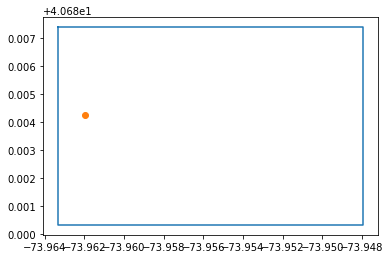

In [111]:
plt.plot(x,y)
pt = (-73.961981, 40.684257)
plt.plot(*pt,"o")

In [112]:
aragon = {"type":"MultiPolygon","coordinates":[[[[-0.747266,42.922374],[-0.724485,42.92023],[-0.736349,42.913019],[-0.717581,42.885839],[-0.678752,42.884536],[-0.602023,42.83215],[-0.60047,42.802429],[-0.569138,42.806856],[-0.567586,42.780628],[-0.529647,42.791558],[-0.505268,42.827426],[-0.441704,42.795371],[-0.394747,42.798967],[-0.313264,42.849373],[-0.188663,42.786941],[-0.159987,42.798029],[-0.106406,42.720616],[-0.06846,42.718074],[-0.062118,42.694589],[-0.016661,42.685111],[0.01581,42.701828],[0.058428,42.697563],[0.084352,42.716163],[0.131622,42.714689],[0.175796,42.737044],[0.260005,42.716015],[0.263695,42.693237],[0.295266,42.673195],[0.360231,42.724349],[0.42209,42.690458],[0.587362,42.694492],[0.597092,42.705522],[0.660068,42.690854],[0.695895,42.658925],[0.703626,42.623826],[0.767525,42.611236],[0.741057,42.544834],[0.749547,42.534881],[0.721162,42.524539],[0.73976,42.50515],[0.690486,42.487622],[0.746097,42.384776],[0.723272,42.36563],[0.771307,42.350643],[0.74036,42.336873],[0.764623,42.322481],[0.702619,42.19004],[0.698726,42.1723],[0.713966,42.163424],[0.695835,42.151998],[0.699551,42.106964],[0.65171,42.026251],[0.662873,42.012234],[0.641928,41.98207],[0.638539,41.994604],[0.61795,41.988925],[0.604356,41.960655],[0.586928,41.966776],[0.56188,41.938219],[0.607487,41.919315],[0.59466,41.917404],[0.592783,41.884415],[0.60716,41.871798],[0.580053,41.85091],[0.554913,41.85279],[0.543875,41.820885],[0.515461,41.822354],[0.483232,41.801463],[0.468601,41.764976],[0.398676,41.757811],[0.395436,41.731981],[0.384742,41.740312],[0.327017,41.67817],[0.357982,41.63172],[0.349613,41.599464],[0.428494,41.602376],[0.446923,41.542236],[0.396712,41.490303],[0.342024,41.484],[0.355329,41.451759],[0.320036,41.394183],[0.373968,41.351539],[0.348436,41.328871],[0.385664,41.278844],[0.381311,41.23643],[0.322404,41.225241],[0.291988,41.156356],[0.25299,41.150153],[0.247879,41.130142],[0.213948,41.1373],[0.200941,41.12608],[0.201202,41.084681],[0.220077,41.082911],[0.230447,41.055296],[0.217744,41.043655],[0.279658,41.020167],[0.258635,41.01463],[0.293501,40.970561],[0.238908,40.884704],[0.278194,40.820901],[0.23357,40.786993],[0.229967,40.767433],[0.175222,40.754941],[0.175357,40.741131],[0.159181,40.750608],[0.163809,40.723607],[0.112501,40.727137],[0.042175,40.691006],[0.026438,40.694951],[0.015738,40.72843],[-0.064699,40.727407],[-0.126841,40.753317],[-0.144533,40.785443],[-0.164957,40.788631],[-0.197176,40.784456],[-0.224034,40.754158],[-0.235991,40.691108],[-0.306998,40.659497],[-0.328818,40.680279],[-0.377957,40.667536],[-0.370483,40.613592],[-0.293286,40.611041],[-0.301837,40.515404],[-0.277638,40.501532],[-0.27264,40.473762],[-0.347355,40.44394],[-0.28539,40.386492],[-0.281762,40.365698],[-0.340617,40.339991],[-0.366273,40.305052],[-0.388637,40.306937],[-0.400408,40.294853],[-0.383626,40.264848],[-0.428072,40.243803],[-0.494515,40.228732],[-0.544187,40.251659],[-0.57864,40.137335],[-0.628533,40.102578],[-0.613589,40.070013],[-0.627222,40.076202],[-0.68294,40.044225],[-0.753621,40.046608],[-0.777646,39.998407],[-0.837795,39.976808],[-0.840423,39.92495],[-0.797695,39.881067],[-0.86742,39.846778],[-0.912564,39.872355],[-0.902659,39.93185],[-0.920454,39.964404],[-0.931886,39.956077],[-0.989381,39.981827],[-1.105015,39.974975],[-1.121748,39.960851],[-1.142395,39.971841],[-1.165188,40.010096],[-1.084228,40.036208],[-1.072129,40.060484],[-1.148034,40.114497],[-1.244592,40.115803],[-1.244296,40.145969],[-1.284342,40.171497],[-1.293083,40.206923],[-1.297785,40.211533],[-1.32299,40.184856],[-1.319722,40.146395],[-1.357099,40.128887],[-1.433319,40.139475],[-1.448856,40.145342],[-1.439208,40.197014],[-1.474416,40.185042],[-1.510902,40.203715],[-1.540483,40.190804],[-1.690346,40.30966],[-1.72122,40.2787],[-1.72946,40.302908],[-1.697677,40.321292],[-1.777769,40.391878],[-1.806359,40.39823],[-1.80205,40.411339],[-1.785434,40.413183],[-1.7486,40.462897],[-1.692512,40.486824],[-1.701624,40.541096],[-1.678101,40.590952],[-1.598749,40.562054],[-1.545515,40.595195],[-1.564856,40.614742],[-1.535638,40.687019],[-1.562017,40.739752],[-1.539908,40.760733],[-1.542334,40.811219],[-1.621392,40.8804],[-1.607904,40.92762],[-1.617449,40.943733],[-1.803291,41.089895],[-1.932447,41.13859],[-1.959017,41.172486],[-2.051693,41.146849],[-2.079896,41.170984],[-2.146242,41.184395],[-2.173671,41.288085],[-2.163137,41.35535],[-2.116033,41.382047],[-2.116767,41.424947],[-2.10152,41.445789],[-2.035623,41.426889],[-2.043575,41.397149],[-2.02927,41.384158],[-1.937295,41.407854],[-1.953686,41.424263],[-1.953276,41.462451],[-1.981112,41.486435],[-1.967335,41.546067],[-1.993686,41.577087],[-1.993238,41.60051],[-1.9231,41.598335],[-1.858991,41.66153],[-1.806224,41.664263],[-1.812074,41.686454],[-1.786862,41.699431],[-1.775372,41.724789],[-1.809213,41.736664],[-1.805853,41.755084],[-1.852918,41.789564],[-1.819054,41.828753],[-1.817601,41.85338],[-1.857281,41.909515],[-1.865188,41.977602],[-1.844045,41.987334],[-1.847185,42.007999],[-1.833703,41.995065],[-1.766896,41.995789],[-1.715221,41.956963],[-1.654146,41.965351],[-1.559256,41.913944],[-1.410756,41.918955],[-1.33952,42.018014],[-1.304822,42.042949],[-1.310593,42.072313],[-1.352277,42.07307],[-1.36676,42.106961],[-1.398881,42.126219],[-1.391906,42.181418],[-1.41753,42.212368],[-1.391371,42.272117],[-1.399082,42.2913],[-1.329083,42.355385],[-1.359905,42.378039],[-1.341508,42.423938],[-1.27278,42.481899],[-1.288137,42.52279],[-1.264769,42.556803],[-1.226166,42.542244],[-1.202791,42.54966],[-1.20192,42.578239],[-1.158035,42.599154],[-1.179775,42.610624],[-1.157116,42.610891],[-1.152046,42.647884],[-1.051926,42.642594],[-1.036808,42.651638],[-1.027981,42.70006],[-0.948676,42.711452],[-0.922985,42.744001],[-0.900499,42.743086],[-0.900535,42.760466],[-0.864838,42.763354],[-0.847533,42.78592],[-0.860007,42.798562],[-0.856833,42.846885],[-0.818533,42.869367],[-0.819095,42.900669],[-0.747266,42.922374]],[[-1.125577,42.455863],[-1.108017,42.441319],[-1.051014,42.441462],[-1.091664,42.485733],[-1.125577,42.455863]],[[-1.148985,42.432848],[-1.182826,42.424591],[-1.187799,42.40303],[-1.15877,42.409663],[-1.148985,42.432848]]]]}

In [117]:
ar = aragon["coordinates"][0][0]

In [119]:
x = [e[0] for e in ar]
y = [e[1] for e in ar]

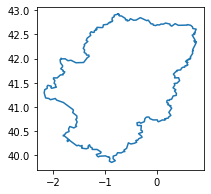

In [121]:
plt.figure(figsize=(3,3))
plt.plot(x,y)

In [124]:
query = {
    "coord":{
        "$geoWithin":{
            "$geometry":aragon
        }
    }
}

res = offices.find(query,{"offices":1})

In [125]:
len(list(res))

4

In [126]:
import json

In [127]:
with open("data/spain.geojson", "r") as file:
    spain = json.loads(file.read())

In [128]:
type(spain)

dict

In [129]:
spain.keys()

dict_keys(['type', 'features'])

In [131]:
ac = spain["features"]

In [132]:
type(ac)

list

In [135]:
ac = {com["properties"]["name"]:com["geometry"] for com in ac}

In [140]:
ac.keys()

dict_keys(['Castilla-Leon', 'Cataluña', 'Ceuta', 'Murcia', 'La Rioja', 'Baleares', 'Canarias', 'Cantabria', 'Andalucia', 'Asturias', 'Valencia', 'Melilla', 'Navarra', 'Galicia', 'Aragon', 'Madrid', 'Extremadura', 'Castilla-La Mancha', 'Pais Vasco'])

# Challenge
- Count how many companies from our dataset are in each AC of Spain

In [137]:
comp_spain = {}

In [ ]:
for community, geometry in ac.items():
    query = {
                "coord":{
                    "$geoWithin":{
                        "$geometry":geometry
                    }
                }
            }
    res = offices.find(query)
    comp_spain[community] = list(res)

### Further resources
- [A lot of GeoJson](https://github.com/codeforamerica/click_that_hood/tree/master/public/data)